In [1]:
#import the library
import numpy as np
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from pyroomacoustics.doa import circ_dist
import math
import os, csv
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
######
# We define a meaningful distance measure on the circle
# Location of original source
azimuth = 61.0 / 180.0 * np.pi  # 60 degrees
distance = 3.0  # 3 meters

In [3]:
#######################
# algorithms parameters
SNR = 0.0  # signal-to-noise ratio
c = 343.0  # speed of sound
fs = 16000  # sampling frequency
nfft = 256  # FFT size
freq_bins = np.arange(5, 60)  # FFT bins to use for estimation

In [4]:
# compute the noise variance
sigma2 = 10 ** (-SNR / 10) / (4.0 * np.pi * distance) ** 2

In [5]:
# Create an anechoic room
def create_room(room_sizeX, room_sizeY, sound_source, mircophone_source):
    room_dim = np.r_[room_sizeX, room_sizeY]
    aroom = pra.ShoeBox(room_dim, fs=fs, max_order=0, sigma2_awgn=sigma2)
    
    # add the source
    source_location = sound_source
    source_signal = np.random.randn((nfft // 2 + 1) * nfft)
    aroom.add_source(source_location, signal=source_signal)
    
    # We use a circular array with radius 15 cm # and 12 microphones
    R = pra.circular_2D_array(mircophone_source, 12, 0.0, 0.15)
    aroom.add_microphone_array(pra.MicrophoneArray(R, fs=aroom.fs))
    
    return aroom, R, source_location

In [6]:
degree_cal = []
degree_error = []

def stft_plot_cal(roomcal, R):
    X = np.array(
        [
            pra.transform.stft.analysis(signal, nfft, nfft // 2).T
            for signal in roomcal.mic_array.signals
        ]
    ) # Compute the STFT frames needed
    
    #algo calculate
#     algo_names = sorted(pra.doa.algorithms.keys())
    algo_names = ['CSSM']

    for algo_name in algo_names:
        # Construct the new DOA object
        # the max_four parameter is necessary for FRIDA only
        doa = pra.doa.algorithms[algo_name](R, fs, nfft, c=c, max_four=4)

        # this call here perform localization on the frames in X
        doa.locate_sources(X, freq_bins=freq_bins)

#         doa.polar_plt_dirac()
#         plt.title(algo_name)

        # doa.azimuth_recon contains the reconstructed location of the source        
        degree_cal = doa.azimuth_recon / np.pi * 180.0
        degree_error = circ_dist(azimuth, doa.azimuth_recon)/ np.pi * 180.0
        
        print(degree_cal, degree_error)
        
    return degree_cal, degree_error

#     plt.show()

In [7]:
# def slope_between(x1,y1,x2,y2):
#     x = (y2 - y1) / (x2 - x1)
#     return x

# slope_value = slope_between(mircrophone_position1[0], mircrophone_position1[1], mircrophone_position2[0], mircrophone_position2[0])

# print(f"The slope between the cordinate {slope_value}")


In [8]:
mircrophone_position1 = [9, 6]
mircrophone_position2 = [12, 8]

Original location of sound source [30, 25] and location of microphone 1 [9, 6]
Original location of sound source [30, 25] and location of microphone 2 [12, 8]


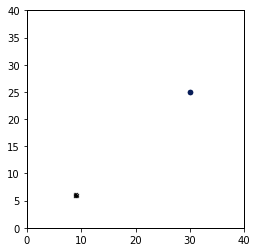

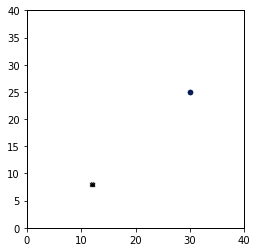

In [9]:
#add sound source position
sound_position_new = [30, 25]

#room dimension
xRoom_new = 40.0
xRoom_new = 40.0

room1_new, R1_new, source_location1_new = create_room(xRoom_new, xRoom_new, sound_position_new, mircrophone_position1)
room1_new.simulate()

print(f"Original location of sound source {source_location1_new} and location of microphone 1 {mircrophone_position1}")

room2_new, R2_new, source_location2_new = create_room(xRoom_new, xRoom_new, sound_position_new, mircrophone_position2)
room2_new.simulate()

print(f"Original location of sound source {source_location2_new} and location of microphone 2 {mircrophone_position2}")

fig, ax = room1_new.plot()


fig, ax = room2_new.plot()

In [10]:
first_degree1_new, first_error1_new = stft_plot_cal(room1_new, R1_new)

if first_degree1_new > 90:
    print(360 - first_degree1_new)

[42.] [19.]


In [11]:
first_degree2_new, first_error2_new = stft_plot_cal(room2_new, R2_new)
if first_degree2_new > 90:
    print(360 - first_degree2_new)

[43.] [18.]


In [12]:
dist = math.sqrt((mircrophone_position1[0] - mircrophone_position2[0])**2 + (mircrophone_position1[1] - mircrophone_position2[1])**2)

print(f"This distance between point is {dist}")

This distance between point is 3.605551275463989


In [13]:
#import csv file and read it 

metadata_path='metadata/'
metadata = pd.read_csv(metadata_path + 'location_cordinate.csv')
metadata.head()

,Cordinate A1,Cordinate A2,Cordinate B1,Cordinate B2,Distance Between microphone A and B,Actual X-value,Actual Y-value
0,2,2,3,6,4.123,5.0,5.0
1,2,2,3,6,4.123,8.3,8.4
2,2,2,3,6,4.123,8.0,1.0
3,2,2,3,6,4.123,5.0,7.0
4,2,2,3,6,4.123,10.0,8.0


Original location of sound source [5.0, 5.0] and location of microphone 1 [2.0, 2.0]
Original location of sound source [5.0, 5.0] and location of microphone 2 [3.0, 6.0]
[45.] [16.]
[333.] [88.]
Original location of sound source [8.3, 8.4] and location of microphone 1 [2.0, 2.0]
Original location of sound source [8.3, 8.4] and location of microphone 2 [3.0, 6.0]
[45.] [16.]
[24.] [37.]
Original location of sound source [8.0, 1.0] and location of microphone 1 [2.0, 2.0]
Original location of sound source [8.0, 1.0] and location of microphone 2 [3.0, 6.0]
[351.] [70.]
[315.] [106.]
Original location of sound source [5.0, 7.0] and location of microphone 1 [2.0, 2.0]
Original location of sound source [5.0, 7.0] and location of microphone 2 [3.0, 6.0]
[59.] [2.]
[27.] [34.]
Original location of sound source [10.0, 8.0] and location of microphone 1 [2.0, 2.0]
Original location of sound source [10.0, 8.0] and location of microphone 2 [3.0, 6.0]
[37.] [24.]
[16.] [45.]
Original location of soun

KeyboardInterrupt: 

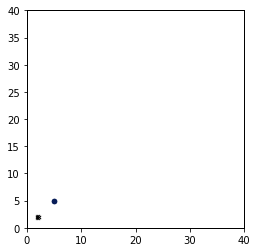

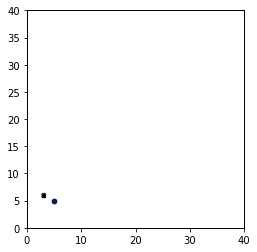

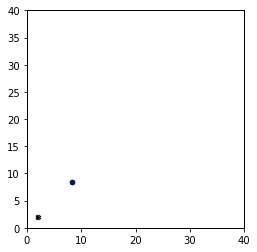

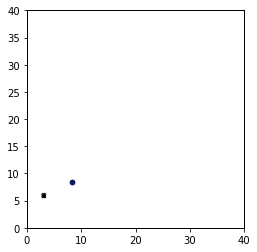

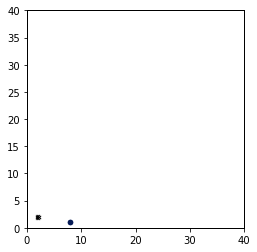

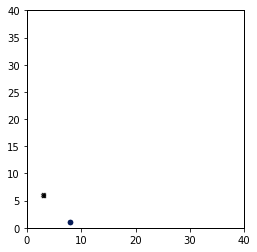

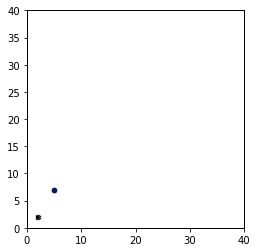

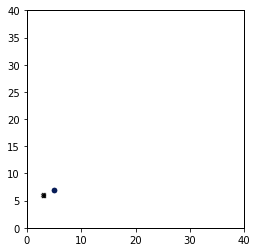

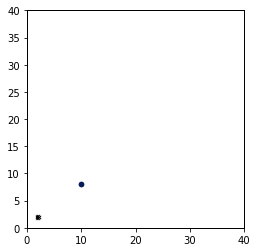

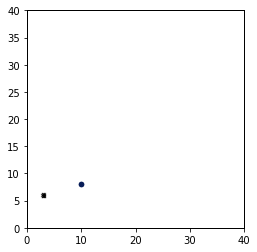

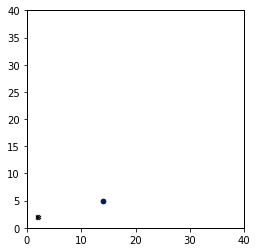

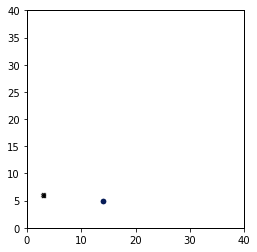

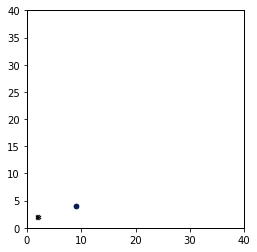

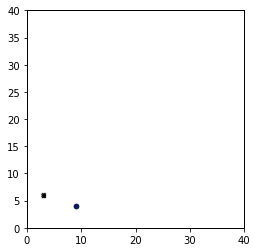

In [17]:
first_degree1_  = [] 
first_error1_  = [] 
first_degree2_  = [] 
first_error2_  = [] 
    
for index, row in metadata.iterrows():

    #add microphone position
    mircrophone_position1 = [row["Cordinate A1"], row["Cordinate A2"]]
    mircrophone_position2 = [row["Cordinate B1"], row["Cordinate B2"]]

    #add sound source position
    sound_position_new = [row["Actual X-value"], row["Actual Y-value"]]

    #room dimension
    xRoom_new = 40.0
    xRoom_new = 40.0

    room1_new, R1_new, source_location1_new = create_room(xRoom_new, xRoom_new, sound_position_new, mircrophone_position1)
    room1_new.simulate()

    print(f"Original location of sound source {source_location1_new} and location of microphone 1 {mircrophone_position1}")

    room2_new, R2_new, source_location2_new = create_room(xRoom_new, xRoom_new, sound_position_new, mircrophone_position2)
    room2_new.simulate()

    print(f"Original location of sound source {source_location2_new} and location of microphone 2 {mircrophone_position2}")

    fig, ax = room1_new.plot()


    fig, ax = room2_new.plot()
    
    first_degree1_new, first_error1_new = stft_plot_cal(room1_new, R1_new)
    
    first_degree2_new, first_error2_new = stft_plot_cal(room2_new, R2_new)
        
    first_degree1_.append(first_degree1_new[0])
    first_error1_.append(first_error1_new[0])
    first_degree2_.append(first_degree2_new[0])
    first_error2_.append(first_error2_new[0])
    


In [15]:
print(first_degree1_)
print(first_degree2_)

[45.0, 45.0, 351.0, 59.00000000000001, 37.0, 14.0, 16.0, 356.0, 353.0, 5.0, 51.0, 73.0, 38.00000000000001, 107.0, 15.0, 99.00000000000001, 281.00000000000006, 18.0, 62.0, 32.0, 346.0, 108.0, 334.0, 17.000000000000004, 59.00000000000001, 48.0, 65.0, 82.0, 72.0, 171.0, 81.0, 59.00000000000001, 33.0, 20.0, 56.0, 302.0, 342.0, 101.0, 80.0, 83.0, 354.0, 99.00000000000001, 51.0, 25.0, 60.99999999999999, 72.0, 48.0, 38.99999999999999, 45.0, 25.0, 355.0, 0.0, 65.0, 9.0, 43.0, 20.0, 14.0, 348.0, 76.00000000000001, 62.99999999999999, 43.0, 43.0, 0.0, 15.0, 113.0, 60.0, 0.0, 77.0, 51.0, 121.00000000000001, 84.0, 198.00000000000003, 54.0, 3.0, 206.99999999999997, 55.00000000000001, 34.00000000000001, 228.00000000000003, 22.0, 62.0, 356.0, 5.0, 230.99999999999997, 6.0, 34.00000000000001, 69.0, 103.00000000000001, 51.0, 104.00000000000001, 38.99999999999999, 60.0, 326.00000000000006, 356.99999999999994, 15.0, 45.0, 0.0, 120.0, 315.0, 87.0]
[333.0, 24.0, 315.0, 27.0, 16.0, 355.0, 342.0, 342.0, 333.0,

In [16]:
# open the file in the write mode
with open('metadata/result.csv', 'w') as f:
    # create the csv writer
    writer = csv.writer(f)

    # write a row to the csv file
    writer.writerow(first_degree2_)
    
    
    

#     if first_degree1_new > 90:
#         print(360 - first_degree1_new)
        
#     if first_degree2_new > 90:
#         print(360 - first_degree2_new)
